In [26]:
# Let's import the needed packages

# Find the El Nino peaks in the signal
from scipy.signal import find_peaks

# To deal with arrays 
import xarray as xr
import pandas as pd 
import numpy as np

# To plot the Nino 3.4 index
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# To plot the map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [27]:
# Data path
sst_data_path = 'data/sst.mnmean.nc'

# Upload the data under a xr array format
sst_ds = xr.open_dataset(sst_data_path)

# Data Structure
print(sst_ds)

<xarray.Dataset> Size: 123MB
Dimensions:    (lat: 180, lon: 360, time: 475, nbnds: 2)
Coordinates:
  * lat        (lat) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 4kB 1981-12-01 1982-01-01 ... 2021-06-01
Dimensions without coordinates: nbnds
Data variables:
    sst        (time, lat, lon) float32 123MB ...
    time_bnds  (time, nbnds) datetime64[ns] 8kB ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Wed Apr  6 13:47:45 2005: ncks -d time,0,278 SAVEs/sst.mn...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Opt

In [28]:
# Plot the dimensions and attributes of the data 
sst_ds.info()

xarray.Dataset {
dimensions:
	lat = 180 ;
	lon = 360 ;
	time = 475 ;
	nbnds = 2 ;

variables:
	float32 lat(lat) ;
		lat:units = degrees_north ;
		lat:long_name = Latitude ;
		lat:actual_range = [ 89.5 -89.5] ;
		lat:standard_name = latitude ;
		lat:axis = Y ;
		lat:coordinate_defines = center ;
	float32 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = Longitude ;
		lon:actual_range = [  0.5 359.5] ;
		lon:standard_name = longitude ;
		lon:axis = X ;
		lon:coordinate_defines = center ;
	float32 sst(time, lat, lon) ;
		sst:long_name = Monthly Mean of Sea Surface Temperature ;
		sst:unpacked_valid_range = [-5. 40.] ;
		sst:actual_range = [-1.7999996 35.56862  ] ;
		sst:units = degC ;
		sst:precision = 2 ;
		sst:var_desc = Sea Surface Temperature ;
		sst:dataset = NOAA Optimum Interpolation (OI) SST V2 ;
		sst:level_desc = Surface ;
		sst:statistic = Mean ;
		sst:parent_stat = Weekly Mean ;
		sst:standard_name = sea_surface_temperature ;
		sst:cell_methods = time: mean (monthly fr

In [29]:
# Now we have to restrict the zone to study and label the El-Nino temperature anomalies
# https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/enso_advisory/enso-alert-readme.shtml#:~:text=The%20Climate%20Prediction%20Center%20defines...%20%22El%20Ni%C3%B1o%20conditions%22,Ni%C3%B1o%20Index%20%28ONI%29%20threshold%20will%20be%20met%2C%20AND
# Niño 3.4 Zone(5°N-5°S, 170°W-120°W)

#Latitudes: convert 5°N-5°S to the format [-90°, 90°] N->S
nino_lat_min = -5  
nino_lat_max = 5   

# Longitudes : convert 170°W and 120°W to the format [0°E, 360°E]
# 170°W = 360 - 170 = 190°E
# 120°W = 360 - 120 = 240°E
nino_lon_min = 190  
nino_lon_max = 240 

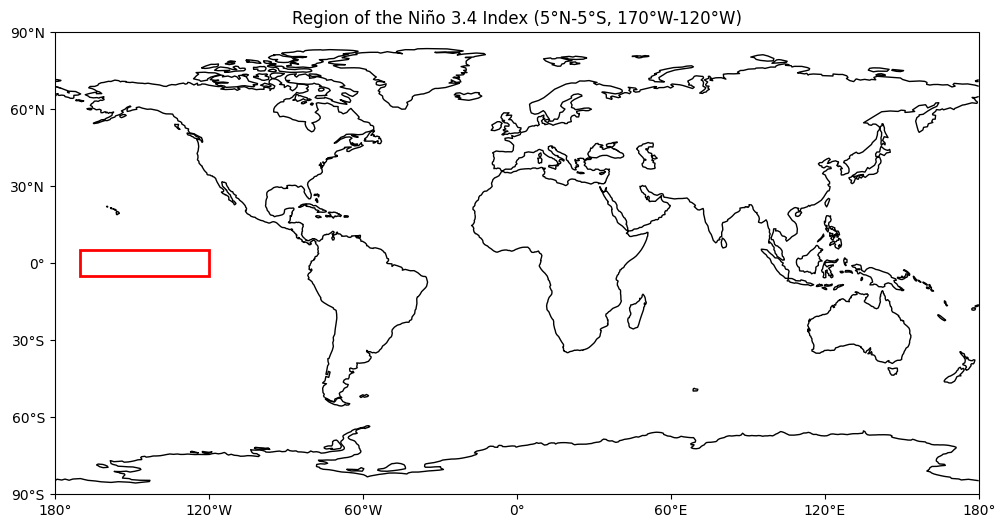

In [30]:
# Let's vizualize the Nino 3.4 zone 
plt.figure(figsize = [12, 6])
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()

# Define the box of the restricted area 
nino34_box = patches.Rectangle(xy = [nino_lon_min, nino_lat_min], width = nino_lon_max - nino_lon_min, height = nino_lat_max - nino_lat_min, linewidth = 2, edgecolor = 'red', facecolor = 'none', transform = ccrs.PlateCarree())
ax.add_patch(nino34_box)

# Add Labels and Title
ax.set_xticks(range(-180, 181, 60), crs = ccrs.PlateCarree())
ax.set_yticks(range(-90, 91, 30), crs = ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.title("Region of the Niño 3.4 Index (5°N-5°S, 170°W-120°W)")
plt.savefig("images/El_Nino_Index_3.4.png")

plt.show()

In [31]:
#Let's now focus on the temperature variation on the Nino 3.4 zone 

# We define the Nino 3.4 region 
nino34_zone = sst_ds.sst.where(
    (sst_ds.lat >= nino_lat_min) & (sst_ds.lat <= nino_lat_max) &
    (sst_ds.lon >= nino_lon_min) & (sst_ds.lon <= nino_lon_max), drop=True #drops data outside of the box
)

# We average data on the Nino 3.4 zone and substract the temporal mean to establish a baseline
nino_sst_anomaly = nino34_zone.mean(dim = ["lat", "lon"]) - nino34_zone.mean(dim = ["lat", "lon"]).mean(dim = "time")


nino_months = nino_sst_anomaly.where(nino_sst_anomaly >= 0.5, drop = True)

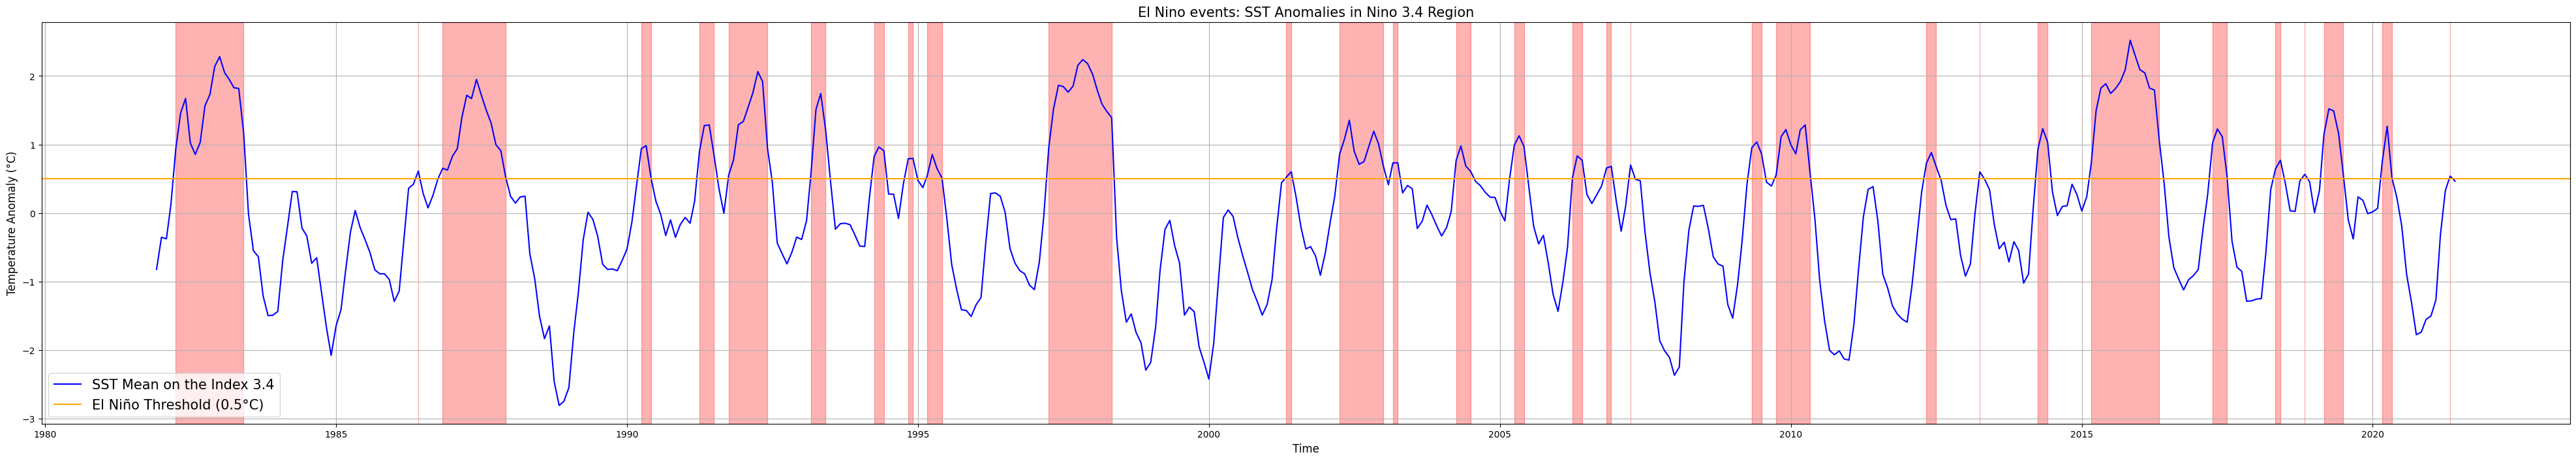

In [32]:
# Let's visualize the Nino Events 

plt.figure(figsize=(50, 8))
nino_sst_anomaly.plot(label = "SST Mean on the Index 3.4", color = "blue")

el_nino_periods = (nino_sst_anomaly >= 0.5).astype(int)

# Find the transitions between neutral and non-nino
transitions = np.diff(el_nino_periods, prepend = 0, append = 0)
start_indices = np.where(transitions == 1)[0]  # Beginning of a Nino phase
end_indices = np.where(transitions == -1)[0]  # End of a Nino phase 

# Add a color to show the Nino periods
for start, end in zip(start_indices, end_indices):
    plt.axvspan(nino_sst_anomaly.time[start].values, nino_sst_anomaly.time[end - 1].values, color = 'red', alpha = 0.3)

# Show the decision threshold
plt.axhline(0.5, color = 'orange', label = "El Niño Threshold (0.5°C)")

# Add Titles and legends
plt.title("El Nino events: SST Anomalies in Nino 3.4 Region", fontsize = 15)
plt.xlabel("Time", fontsize = 12)
plt.ylabel("Temperature Anomaly (°C)", fontsize = 12)
plt.legend(fontsize = 15)
plt.grid(True)

# Sauvegarder le graphique
plt.savefig("images/Temperatures_anomalies.png", dpi=300)
plt.show()

In [33]:
# Let's Print the El Nino Events  

nino_event_months = pd.to_datetime(nino_months.time.values)

print("Dates of the El Nino Events:", nino_event_months)

Dates of the El Nino Events: DatetimeIndex(['1982-04-01', '1982-05-01', '1982-06-01', '1982-07-01',
               '1982-08-01', '1982-09-01', '1982-10-01', '1982-11-01',
               '1982-12-01', '1983-01-01',
               ...
               '2018-11-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2021-05-01'],
              dtype='datetime64[ns]', length=149, freq=None)


In [34]:
# Let's create our dataset for the prediction 1 month in advance
# We have to suppress the First and the Last month of the original dataset
all_months = pd.to_datetime(nino_sst_anomaly.time.values)

# Let's create y: assign 1 if there is a El Nino event in the following month, 0 otherwise 
y_1m = []
for i in range(0, len(all_months) - 1): 
    next_month = all_months[i + 1]
    if next_month in nino_event_months:
        y_1m.append(1)
    else:
        y_1m.append(0)

y_1m = np.array(y_1m)

# Let's create X: extract the SST data for all valid months
sst_global_data = sst_ds.sst.sel(time = slice(all_months[0], all_months[-2]))
X_1m = sst_global_data.values.reshape(len(all_months) - 1, -1)  #Flatten the data by month 

# Verify that the size are correct 
print(X_1m.shape, y_1m.shape)

#Save the data under the format .npz
np.savez_compressed("data/preprocessed_data/nino_dataset_1m.npz", X=X_1m, y=y_1m)


(474, 64800) (474,)


In [35]:
# Prediction 2 months in advance
# We have to suppress the last two months of the original dataset

y_2m = []
for i in range(0, len(all_months) - 2):  # Stop 2 months before the end
    next_2_months = all_months[i + 2]
    if next_2_months in nino_event_months:
        y_2m.append(1)
    else:
        y_2m.append(0)

y_2m = np.array(y_2m)

# Extract SST data for all months, excluding the last two 
sst_global_data_2m = sst_ds.sst.sel(time = slice(all_months[0], all_months[-3]))
X_2m = sst_global_data_2m.values.reshape(len(all_months) - 2, -1)  # Flatten the data by month

# Verify sizes
print(X_2m.shape, y_2m.shape)

# Save the dataset
np.savez_compressed("data/preprocessed_data/nino_dataset_2m.npz", X = X_2m, y = y_2m)

(473, 64800) (473,)


In [36]:
# Prediction 3 months in advance
# We have to suppress the last three months of the original dataset
y_3m = []
for i in range(0, len(all_months) - 3):  # Stop 3 months before the end
    next_3_months = all_months[i + 3]
    if next_3_months in nino_event_months:
        y_3m.append(1)
    else:
        y_3m.append(0)

y_3m = np.array(y_3m)

# Extract SST data for all valid months, excluding the last three months
sst_global_data_3m = sst_ds.sst.sel(time = slice(all_months[0], all_months[-4]))
X_3m = sst_global_data_3m.values.reshape(len(all_months) - 3, -1)  # Flatten the data by month

# Verify sizes
print(X_3m.shape, y_3m.shape)

# Save the dataset
np.savez_compressed("data/preprocessed_data/nino_dataset_3m.npz", X = X_3m, y = y_3m)


(472, 64800) (472,)
